In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")


/Users/rayyi/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.static import teams
import time
import ast
from sklearn.preprocessing import StandardScaler

import difflib


# Dataset 1: NBA_API

## Build Players Dataset

#### Note: The commented cells below contain code to scrape data from the API, we later read the csv files locally so there's no need to run these blocks

In [3]:
seasons = ['2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20']
# sample_gamelog = teamplayerdashboard.TeamPlayerDashboard(team_id = '1610612744').get_data_frames()[1]

In [4]:
# full_gamelog2 = pd.DataFrame(columns=sample_gamelog.columns.tolist()+["SEASON", "TEAM", "TEAM_ID"])

# timer_count = 0
# for i, item in enumerate(teams.get_teams()):
#     for j in seasons:
#         print("[{}] collecting team {}...".format(i, item['id']))
#         try:
#             gamelog = teamplayerdashboard.TeamPlayerDashboard(team_id = item['id'],season=j).get_data_frames()[1]
#             gamelog["SEASON"] = j
#             gamelog["TEAM"] = item["full_name"]
#             gamelog["TEAM_ID"] = item["id"]
#             full_gamelog2 = full_gamelog2.append(gamelog, ignore_index = True)
#         except:
#             print("Time out occurred. Saving file...")
#             full_gamelog2.to_csv("/Users/rayyi/STATS_120A/NBA/full_team_player_v2.csv")
        
#         timer_count += 1
        
#         if timer_count % 5 == 0:
#             time.sleep(5)
#             print("Sleeping ...")
        
# print("api call complete. Saving full player file...")
# full_gamelog2.to_csv("/Users/rayyi/STATS_120A/NBA/full_team_player_v2.csv")

## Build Teams Roster

In [5]:
# teams = full_gamelog2["TEAM_ID"].unique().tolist()
# seasons = full_gamelog2["SEASON"].unique().tolist()

# players = []
# teams_list = []
# seasons_list = []

# timeout_count = 0
# for team in teams:
#     for season in seasons:
#         print("Collecting {} roster for {}...".format(team, season))
#         roster_data = teamplayerdashboard.TeamPlayerDashboard(team_id=team, season=season).get_data_frames()[1]
#         players.append(roster_data["PLAYER_NAME"].tolist())
#         teams_list.append(team)
#         seasons_list.append(season)
        
#         timeout_count += 1
#         if timeout_count % 5 == 0:
#             print("Sleeping...")
#             time.sleep(5)
        
# roster_df = pd.DataFrame()
# roster_df["TEAM"] = teams_list
# roster_df["SEASON"] = seasons_list
# roster_df["PLAYERS"] = players

In [6]:
# roster_df.to_csv("./data/team_rosters.csv")

## Build Team Season Win %

In [7]:
# seasons = ['2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20']
# sample_gamelog = teamplayerdashboard.TeamPlayerDashboard(team_id = '1610612744').get_data_frames()[0]
# # full_gamelog1 = pd.DataFrame(columns=sample_gamelog.columns)

# full_gamelog1 = pd.DataFrame()

# for i, item in enumerate(teams.get_teams()):
#     for j in seasons:
#         print("[{}] collecting team {}...".format(i, item['id']))

#         try:
#             gamelog = teamplayerdashboard.TeamPlayerDashboard(team_id = item['id'],season=j).get_data_frames()[0]
#             full_gamelog1 = full_gamelog1.append(gamelog, ignore_index = True)
#         except:
#             print("Time out occurred. Saving file...")
#             full_gamelog1.to_csv("/Users/rayyi/STATS_120A/NBA/full_teams_data.csv")

#         if i % 5 == 0:
#             time.sleep(5)
#             print("Sleeping ...")

# print("api call complete. Saving full player file...")
# full_gamelog1.to_csv("./data/full_teams_data.csv")

## Read in Data

In [8]:
# player df
dfp = pd.read_csv("./data/full_team_player_v2.csv")

# team df
dft = pd.read_csv("./data/full_teams_data.csv")

# team roster df
dfr = pd.read_csv("./data/team_rosters.csv")
dfr = dfr.set_index(["TEAM", "SEASON"])

# joined player df
new_df = pd.read_csv("./data/joined_player_data.csv")

## Build Team Aggregated Scores

In [9]:
def get_weighted_means(x):

    interested_vars = ['W_PCT', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
                       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
                       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
                       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48','OBPM', 'DBPM', 'BPM', 'VORP']
    
    return pd.Series(np.average(x[interested_vars], weights=x["MIN_WEIGHT"], axis=0), interested_vars) 

In [10]:
interested_vars = ['W_PCT', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
                       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
                       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
                       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48','OBPM', 'DBPM', 'BPM', 'VORP']


In [11]:
def generate_projected_team_stats(data, players, seasons):    
    selected_stats = data[(data["PLAYER_NAME"].isin(players)) & (data["SEASON"].isin(seasons))].copy()

    # computes weights by # minutes played per player by season
    selected_stats["MIN_WEIGHT"] = selected_stats.groupby("SEASON")["MIN"].apply(lambda x: x/x.sum())
    
    
    projected_team_stats = selected_stats.groupby("SEASON").apply(get_weighted_means)   
    projected_team_stats.rename(columns={'W_PCT':'PLAYER_W_PCT'}, inplace=True)
    
    return projected_team_stats

**Testing aggregation methods**

In [12]:
# test projected team stats function with random data
#players = dfp.sample(7)["PLAYER_ID"].tolist()

team_id = 1610612737  #atlanta hawks
season_id = '2016-17'#

prev_seasons = seasons[:seasons.index(season_id)]
players_list = ast.literal_eval(dfr.loc[team_id, season_id]["PLAYERS"]) 
# result_means = generate_projected_team_stats(dfp, players_list, prev_seasons)
result_means = generate_projected_team_stats(new_df, players_list, prev_seasons)


In [13]:
# # this is how the players in [player_list] performed in their past seasons
result_means

,PLAYER_W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
SEASON,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-13,0.531541,295.692361,608.589986,0.479952,74.754045,175.426803,0.344374,138.984606,214.688295,0.772785,97.988691,310.031905,408.020596,143.277055,99.405273,63.261645,56.364033,35.686105,166.947937,196.067484,805.123373,101.353680,1769.135431,11.861582,0.133868,16.090188,0.575402,0.318205,0.313918,5.345277,16.737961,11.081340,13.211347,1.612518,1.839319,12.193920,18.442767,3.120502,2.410417,5.523564,0.132415,0.804716,0.250588,1.081371,1.642210
2013-14,0.491838,290.528065,622.753015,0.458122,83.297086,212.192473,0.336489,133.745471,187.570968,0.786085,73.629343,262.958940,336.588282,150.765061,100.192922,58.267018,37.718966,30.268087,144.074247,166.037402,798.098686,22.622038,1615.917249,8.899114,0.102012,14.710083,0.558413,0.348298,0.284258,4.404843,15.222984,9.862866,12.356330,1.521479,1.447617,12.250279,19.389628,2.445984,1.990616,4.435298,0.100093,0.018169,-0.117038,-0.067570,1.239080
2014-15,0.586982,234.257127,520.697923,0.446622,76.454019,193.077809,0.361302,104.841602,138.801398,0.779865,51.153422,217.915772,269.069194,133.019707,83.163551,46.518587,26.498031,29.639544,123.705978,127.889390,649.809874,87.391597,1308.108769,4.212410,0.000000,14.324070,0.552711,0.366745,0.260071,4.044613,15.573899,9.874435,13.515852,1.482515,1.335068,12.241814,19.405367,1.858338,1.685761,3.567924,0.101698,-0.086747,-0.227706,-0.304255,0.885241
2015-16,0.527029,253.224406,539.484235,0.464311,66.114872,182.402035,0.316868,110.402120,160.670103,0.755420,72.309386,271.410625,343.720012,149.473054,99.574966,63.861090,43.775289,30.587540,138.473064,150.241733,682.965803,83.249361,1542.973570,8.215276,0.000000,14.154126,0.556167,0.359979,0.279375,4.525346,16.508068,10.578951,12.937796,1.693986,1.800042,13.268313,18.177720,1.628839,2.526140,4.153534,0.108390,-0.668944,0.573380,-0.108004,1.062565


In [14]:
col_names = []
for season in prev_seasons:
    for col in result_means.columns:
        col_names.append(col+'_'+season)
            
item = pd.Series(result_means.values.flatten(), col_names)
item["TEAM_ID"] = team_id
item["GROUP_VALUE"] = season_id

In [15]:
dft.head()

,Unnamed: 0,GROUP_SET,TEAM_ID,TEAM_NAME,GROUP_VALUE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,0,Overall,1610612737,Atlanta Hawks,2012-13,82,44,38,0.537,3971.0,3084,6644,0.464,706,1901,0.371,1158,1619,0.715,758,2593,3351,2007,1219.0,664,369,350,1473,1543,8032,33.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,Overall,1610612737,Atlanta Hawks,2013-14,82,38,44,0.463,3966.0,3061,6688,0.458,768,2116,0.363,1392,1782,0.781,713,2565,3278,2041,1251.0,680,326,354,1577,1643,8282,-39.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2,Overall,1610612737,Atlanta Hawks,2014-15,82,60,22,0.732,3946.0,3121,6699,0.466,818,2152,0.380,1349,1735,0.778,715,2611,3326,2111,1167.0,744,380,404,1457,1611,8409,445.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,3,Overall,1610612737,Atlanta Hawks,2015-16,82,48,34,0.585,3966.0,3168,6923,0.458,815,2326,0.350,1282,1638,0.783,679,2772,3451,2100,1226.0,747,486,411,1570,1500,8433,296.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,4,Overall,1610612737,Atlanta Hawks,2016-17,82,43,39,0.524,3976.0,3123,6918,0.451,729,2137,0.341,1484,2039,0.728,842,2793,3635,1938,1294.0,672,397,424,1491,1768,8459,-70.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


##  WIN % Prediction

In [16]:
dfts = dft[["TEAM_ID", "TEAM_NAME", "GROUP_VALUE", "W", "L", "W_PCT"]].copy()

In [17]:
dfts.head()

,TEAM_ID,TEAM_NAME,GROUP_VALUE,W,L,W_PCT
0,1610612737,Atlanta Hawks,2012-13,44,38,0.537
1,1610612737,Atlanta Hawks,2013-14,38,44,0.463
2,1610612737,Atlanta Hawks,2014-15,60,22,0.732
3,1610612737,Atlanta Hawks,2015-16,48,34,0.585
4,1610612737,Atlanta Hawks,2016-17,43,39,0.524


In [18]:
def expand_projected_team_stats(dfts, dfpc, dfr):
    seasons = ['2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
    projected_data = []
    for i in range(len(dfts)):
        if dfts.iloc[i]["GROUP_VALUE"] != "2012-13":
            team_id = dfts.iloc[i]["TEAM_ID"]
            season_id = dfts.iloc[i]["GROUP_VALUE"]
            
            print("Computing projected team stats for {} in {}".format(team_id, season_id))
            
            # get all players that played on [team_id] during [season_id]
            players_list = ast.literal_eval(dfr.loc[team_id, season_id]["PLAYERS"]) 

            # get all seasons before current season
            prev_seasons = seasons[:seasons.index(dfts.iloc[i]["GROUP_VALUE"])]
            
            projected_stats = generate_projected_team_stats(dfpc, players_list, prev_seasons)
            
            col_names = []
            #print()
            for season in prev_seasons:
                for col in result_means.columns:
                    col_names.append(col+'_'+season)
            
            item = pd.Series(projected_stats.values.flatten(), col_names)
            item["TEAM_ID"] = team_id
            item["GROUP_VALUE"] = season_id
            
            projected_data.append(item)
    
    return pd.DataFrame(projected_data)

In [19]:
# result = expand_projected_team_stats(dft, dfp, dfr)

In [20]:
# result.head()

In [21]:
# # merge team data with projected player aggregation data
# result['TEAM_ID'] = result['TEAM_ID'].astype(int)
# results_merged = dfts.merge(result, on=['TEAM_ID', 'GROUP_VALUE'])

In [22]:
# results_merged.head()

In [23]:
# results_merged.to_csv("./data/win_pct_pred_data_v2.csv")

In [24]:
wpdf = pd.read_csv("./data/win_pct_pred_data_v2.csv")

In [25]:
wpdf.head()

,Unnamed: 0,TEAM_ID,TEAM_NAME,GROUP_VALUE,W,L,W_PCT,PLAYER_W_PCT_2012-13,FGM_2012-13,FGA_2012-13,FG_PCT_2012-13,FG3M_2012-13,FG3A_2012-13,FG3_PCT_2012-13,FTM_2012-13,FTA_2012-13,FT_PCT_2012-13,OREB_2012-13,DREB_2012-13,REB_2012-13,AST_2012-13,TOV_2012-13,STL_2012-13,BLK_2012-13,BLKA_2012-13,PF_2012-13,PFD_2012-13,PTS_2012-13,PLUS_MINUS_2012-13,NBA_FANTASY_PTS_2012-13,DD2_2012-13,TD3_2012-13,GP_RANK_2012-13,W_RANK_2012-13,L_RANK_2012-13,W_PCT_RANK_2012-13,MIN_RANK_2012-13,FGM_RANK_2012-13,FGA_RANK_2012-13,FG_PCT_RANK_2012-13,FG3M_RANK_2012-13,FG3A_RANK_2012-13,FG3_PCT_RANK_2012-13,FTM_RANK_2012-13,FTA_RANK_2012-13,FT_PCT_RANK_2012-13,OREB_RANK_2012-13,DREB_RANK_2012-13,REB_RANK_2012-13,AST_RANK_2012-13,TOV_RANK_2012-13,STL_RANK_2012-13,BLK_RANK_2012-13,BLKA_RANK_2012-13,PF_RANK_2012-13,PFD_RANK_2012-13,PTS_RANK_2012-13,PLUS_MINUS_RANK_2012-13,NBA_FANTASY_PTS_RANK_2012-13,DD2_RANK_2012-13,TD3_RANK_2012-13,PLAYER_W_PCT_2013-14,FGM_2013-14,FGA_2013-14,FG_PCT_2013-14,FG3M_2013-14,FG3A_2013-14,FG3_PCT_2013-14,FTM_2013-14,FTA_2013-14,FT_PCT_2013-14,OREB_2013-14,DREB_2013-14,REB_2013-14,AST_2013-14,TOV_2013-14,STL_2013-14,BLK_2013-14,BLKA_2013-14,PF_2013-14,PFD_2013-14,PTS_2013-14,PLUS_MINUS_2013-14,NBA_FANTASY_PTS_2013-14,DD2_2013-14,TD3_2013-14,GP_RANK_2013-14,W_RANK_2013-14,L_RANK_2013-14,W_PCT_RANK_2013-14,MIN_RANK_2013-14,FGM_RANK_2013-14,FGA_RANK_2013-14,FG_PCT_RANK_2013-14,FG3M_RANK_2013-14,FG3A_RANK_2013-14,FG3_PCT_RANK_2013-14,FTM_RANK_2013-14,FTA_RANK_2013-14,FT_PCT_RANK_2013-14,OREB_RANK_2013-14,DREB_RANK_2013-14,REB_RANK_2013-14,AST_RANK_2013-14,TOV_RANK_2013-14,STL_RANK_2013-14,BLK_RANK_2013-14,BLKA_RANK_2013-14,PF_RANK_2013-14,PFD_RANK_2013-14,PTS_RANK_2013-14,PLUS_MINUS_RANK_2013-14,NBA_FANTASY_PTS_RANK_2013-14,DD2_RANK_2013-14,TD3_RANK_2013-14,PLAYER_W_PCT_2014-15,FGM_2014-15,FGA_2014-15,FG_PCT_2014-15,FG3M_2014-15,FG3A_2014-15,FG3_PCT_2014-15,FTM_2014-15,FTA_2014-15,FT_PCT_2014-15,OREB_2014-15,DREB_2014-15,REB_2014-15,AST_2014-15,TOV_2014-15,STL_2014-15,BLK_2014-15,BLKA_2014-15,PF_2014-15,PFD_2014-15,PTS_2014-15,PLUS_MINUS_2014-15,NBA_FANTASY_PTS_2014-15,DD2_2014-15,TD3_2014-15,GP_RANK_2014-15,W_RANK_2014-15,L_RANK_2014-15,W_PCT_RANK_2014-15,MIN_RANK_2014-15,FGM_RANK_2014-15,FGA_RANK_2014-15,FG_PCT_RANK_2014-15,FG3M_RANK_2014-15,FG3A_RANK_2014-15,FG3_PCT_RANK_2014-15,FTM_RANK_2014-15,FTA_RANK_2014-15,FT_PCT_RANK_2014-15,OREB_RANK_2014-15,DREB_RANK_2014-15,REB_RANK_2014-15,AST_RANK_2014-15,TOV_RANK_2014-15,STL_RANK_2014-15,BLK_RANK_2014-15,BLKA_RANK_2014-15,PF_RANK_2014-15,PFD_RANK_2014-15,PTS_RANK_2014-15,PLUS_MINUS_RANK_2014-15,NBA_FANTASY_PTS_RANK_2014-15,DD2_RANK_2014-15,TD3_RANK_2014-15,PLAYER_W_PCT_2015-16,FGM_2015-16,FGA_2015-16,FG_PCT_2015-16,FG3M_2015-16,FG3A_2015-16,FG3_PCT_2015-16,FTM_2015-16,FTA_2015-16,FT_PCT_2015-16,OREB_2015-16,DREB_2015-16,REB_2015-16,AST_2015-16,TOV_2015-16,STL_2015-16,BLK_2015-16,BLKA_2015-16,PF_2015-16,PFD_2015-16,PTS_2015-16,PLUS_MINUS_2015-16,NBA_FANTASY_PTS_2015-16,DD2_2015-16,TD3_2015-16,GP_RANK_2015-16,W_RANK_2015-16,L_RANK_2015-16,W_PCT_RANK_2015-16,MIN_RANK_2015-16,FGM_RANK_2015-16,FGA_RANK_2015-16,FG_PCT_RANK_2015-16,FG3M_RANK_2015-16,FG3A_RANK_2015-16,FG3_PCT_RANK_2015-16,FTM_RANK_2015-16,FTA_RANK_2015-16,FT_PCT_RANK_2015-16,OREB_RANK_2015-16,DREB_RANK_2015-16,REB_RANK_2015-16,AST_RANK_2015-16,TOV_RANK_2015-16,STL_RANK_2015-16,BLK_RANK_2015-16,BLKA_RANK_2015-16,PF_RANK_2015-16,PFD_RANK_2015-16,PTS_RANK_2015-16,PLUS_MINUS_RANK_2015-16,NBA_FANTASY_PTS_RANK_2015-16,DD2_RANK_2015-16,TD3_RANK_2015-16,PLAYER_W_PCT_2016-17,FGM_2016-17,FGA_2016-17,FG_PCT_2016-17,FG3M_2016-17,FG3A_2016-17,FG3_PCT_2016-17,FTM_2016-17,FTA_2016-17,FT_PCT_2016-17,OREB_2016-17,DREB_2016-17,REB_2016-17,AST_2016-17,TOV_2016-17,STL_2016-17,BLK_2016-17,BLKA_2016-17,PF_2016-17,PFD_2016-17,PTS_2016-17,PLUS_MINUS_2016-17,NBA_FANTASY_PTS_2016-17,DD2_2016-17,TD3_2016-17,GP_RANK_2016-17,W_RANK_2016-17,L_RANK_2016-17,W_PCT_RANK_2016-17,MIN_RANK_2016-17,FGM_RANK_2016-17,FGA_RANK_2016-17,FG_PCT_RANK_2016-17,FG3M_RANK_

In [26]:
bins = []
for x in wpdf["W_PCT"]:
    if x >= 0.5:
        bins.append(1)
    else:
        bins.append(0)

wpdf["W_PCT_BIN"] = bins

In [27]:
# # correlation 

# sdf = wpdf[wpdf["GROUP_VALUE"] == "2017-18"]
# plt.scatter(sdf["W_PCT"], sdf["PLUS_MINUS_2016-17"])
# plt.show()

# Dataset 2: basketball_reference.com

In [28]:
players_2013 = pd.read_csv("./data/2013_players_1.csv")
players_2013['Season'] = '2012-13'
players_2014 = pd.read_csv("./data/2014_players_1.csv")
players_2014['Season'] = '2013-14'
players_2015 = pd.read_csv("./data/2015_players_1.csv")
players_2015['Season'] = '2014-15'
players_2016 = pd.read_csv("./data/2016_players_1.csv")
players_2016['Season'] = '2015-16'
players_2017 = pd.read_csv("./data/2017_players_1.csv")
players_2017['Season'] = '2016-17'
players_2018 = pd.read_csv("./data/2018_players_1.csv")
players_2018['Season'] = '2017-18'
players_2019 = pd.read_csv("./data/2019_players_1.csv")
players_2019['Season'] = '2018-19'
players_2020 = pd.read_csv("./data/2020_players_1.csv")
players_2020['Season'] = '2019-20'
players_2020

all_years = [players_2013,players_2014,players_2015,players_2016,players_2017,players_2018,players_2019,players_2020]
all_players_1 = pd.concat(all_years, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

### Cleaning Dataset 2

In [29]:
# all_players_1['Player_Name'] = all_players_1['Player'].str.split("\\").str[0]

In [30]:
# all_players_1['Player_Name'] = all_players_1['Player_Name'].apply(lambda x: difflib.get_close_matches(x, dfp['PLAYER_NAME'])[0])

In [31]:
# all_players_1.to_csv("./data/basketball_reference_players.csv")

In [32]:
dfp2 = pd.read_csv("./data/basketball_reference_players.csv")

In [33]:
#5004,32
dfp2.sort_values(by=['Tm', 'Season'])
dfp2['Tm'].replace(['ATL','BOS','BRK','CHA','CHI','CHO','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
                     'MIA','MIL','MIN','NOH','NOP','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','TOR','TOT','UTA',
                     'WAS'],['Atlanta Hawks','Boston Celtics','Brooklyn Nets','Charlotte Hornets','Chicago Bulls','Charlotte Hornets',
                             'Cleveland Cavaliers','Dallas Mavericks','Denver Nuggets','Detroit Pistons','Golden State Warriors',
                             'Houston Rockets','Indiana Pacers','Los Angeles Clippers','Los Angeles Lakers','Memphis Grizzlies',
                             'Miami Heat','Milwaukee Bucks','Minnesota Timberwolves','New Orleans Pelicans','New Orleans Pelicans','New York Knicks',
                             'Oklahoma City Thunder','Orlando Magic','Philadelphia 76ers','Phoenix Suns','Portland Trail Blazers','Sacramento Kings',
                             'San Antonio Spurs','Toronto Raptors','TOT','Utah Jazz','Washington Wizards'],inplace=True)

In [34]:
dfp2.head()

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Season,Player_Name
0,0,1,Quincy Acy\acyqu01,PF,22,Toronto Raptors,29,342,15.9,0.632,0.027,0.507,10.3,16.6,13.4,5.2,2.0,3.5,15.6,14.7,NaN,0.7,0.4,1.1,0.157,NaN,-1.0,1.0,0.1,0.2,2012-13,Quincy Acy
1,1,2,Jeff Adrien\adrieje01,PF,26,Charlotte Hornets,52,713,13.4,0.493,0.012,0.595,10.6,21.2,15.7,8.3,1.3,3.1,13.1,15.6,NaN,0.5,0.4,1.0,0.064,NaN,-2.1,-0.9,-3.0,-0.2,2012-13,Jeff Adrien
2,2,3,Arron Afflalo\afflaar01,SF,27,Orlando Magic,64,2307,13.0,0.527,0.265,0.246,1.4,10.3,5.8,14.6,0.9,0.4,12.1,22.5,NaN,1.5,0.5,2.0,0.042,NaN,-1.1,-1.8,-2.9,-0.5,2012-13,Arron Afflalo
3,3,4,Josh Akognon\akognjo01,PG,26,Dallas Mavericks,3,9,15.3,0.625,0.500,0.000,0.0,12.1,6.2,19.4,0.0,0.0,0.0,20.3,NaN,0.0,0.0,0.0,0.196,NaN,-3.1,0.1,-3.0,0.0,2012-13,Josh Akognon
4,4,5,Cole Aldrich\aldrico01,C,24,TOT,45,388,11.1,0.563,0.000,0.250,8.7,26.7,17.7,3.4,0.7,4.6,20.6,12.7,NaN,0.1,0.4,0.6,0.070,NaN,-3.5,0.6,-2.9,-0.1,2012-13,Cole Aldrich


In [35]:
dfp2.columns

Index(['Unnamed: 0', 'Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'Unnamed: 19', 'OWS', 'DWS', 'WS', 'WS/48',
       'Unnamed: 24', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Season', 'Player_Name'],
      dtype='object')

In [36]:
dfp.head()
#dfp.shape #4513,64

,Unnamed: 0,GROUP_SET,PLAYER_ID,PLAYER_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,SEASON,TEAM,TEAM_ID
0,0,Players,201143,Al Horford,74,42,32,0.568,2756.445000,576,1060,0.543,3,6,0.500,134,208,0.644,195,562,757,240,147,78,78,40,163,195,1289,164,2878.4,43,0,3,2,13,4,1,1,2,1,12,14,1,3,3,13,1,1,1,3,3,3,2,16,15,3,2,2,2,1,1,2012-13,Atlanta Hawks,1610612737
1,1,Players,201627,Anthony Morrow,24,17,7,0.708,300.893333,47,111,0.423,15,38,0.395,16,18,0.889,10,16,26,9,4,12,1,7,33,13,125,-36,204.7,0,0,15,13,3,1,15,14,13,12,9,9,4,13,14,3,13,16,15,17,17,11,14,7,5,16,13,12,14,9,1,2012-13,Atlanta Hawks,1610612737
2,2,Players,201229,Anthony Tolliver,62,28,34,0.452,963.160000,82,216,0.380,45,133,0.338,44,51,0.863,31,124,155,32,36,15,12,9,66,44,253,-63,532.0,0,0,6,10,15,16,10,11,11,15,8,8,10,10,11,6,7,7,7,12,10,10,7,8,10,10,11,16,11,9,1,2012-13,Atlanta Hawks,1610612737
3,3,Players,2563,Dahntay Jones,28,13,15,0.464,381.176667,32,82,0.390,3,12,0.250,21,31,0.677,11,20,31,20,16,12,1,5,46,28,88,-54,178.2,0,0,14,14,5,15,12,16,16,14,12,13,13,12,12,12,12,15,14,13,15,11,14,5,7,13,16,14,16,9,1,2012-13,Atlanta Hawks,1610612737
4,4,Players,2052,DeShawn Stevenson,56,30,26,0.536,1157.818333,98,262,0.374,76,209,0.364,12,23,0.522,18,104,122,52,23,29,6,5,69,33,284,-54,590.4,0,0,9,7,11,9,6,10,9,16,4,4,7,14,13,16,10,9,8,9,13,9,12,5,11,12,10,14,10,9,1,2012-13,Atlanta Hawks,1610612737


# Joining 2 Datasets

In [37]:
new_df = dfp.merge(dfp2, how='left', left_on=['PLAYER_NAME','SEASON','TEAM'], right_on = ['Player_Name','Season','Tm'])

In [38]:
#new_df.to_csv("./data/joined_player_data.csv")

In [39]:
# new_df = new_df[['PLAYER_ID', 'PLAYER_NAME', 'GP', 'W', 'L',
#        'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
#        'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
#        'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS',
#        'DD2', 'TD3', 'SEASON', 'TEAM', 'Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER',
#        'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
#        'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Season', 'Player_Name']]

In [40]:
# new_df.head()

In [41]:
# result1 = expand_projected_team_stats(dft, new_df, dfr)

In [42]:
# result1.head()
# result1['TEAM_ID'] = result1['TEAM_ID'].astype(int)
# results_merged_1 = dfts.merge(result1, on=['TEAM_ID', 'GROUP_VALUE'])

In [43]:
# results_merged_1.to_csv("./data/full_team_player_v3.csv")

In [44]:
wpdf1 = pd.read_csv("./data/full_team_player_v3.csv")
wpdf1.head()

,Unnamed: 0,TEAM_ID,TEAM_NAME,GROUP_VALUE,W,L,W_PCT,PLAYER_W_PCT_2012-13,FGM_2012-13,FGA_2012-13,FG_PCT_2012-13,FG3M_2012-13,FG3A_2012-13,FG3_PCT_2012-13,FTM_2012-13,FTA_2012-13,FT_PCT_2012-13,OREB_2012-13,DREB_2012-13,REB_2012-13,AST_2012-13,TOV_2012-13,STL_2012-13,BLK_2012-13,BLKA_2012-13,PF_2012-13,PFD_2012-13,PTS_2012-13,PLUS_MINUS_2012-13,NBA_FANTASY_PTS_2012-13,DD2_2012-13,TD3_2012-13,PER_2012-13,TS%_2012-13,3PAr_2012-13,FTr_2012-13,ORB%_2012-13,DRB%_2012-13,TRB%_2012-13,AST%_2012-13,STL%_2012-13,BLK%_2012-13,TOV%_2012-13,USG%_2012-13,OWS_2012-13,DWS_2012-13,WS_2012-13,WS/48_2012-13,OBPM_2012-13,DBPM_2012-13,BPM_2012-13,VORP_2012-13,PLAYER_W_PCT_2013-14,FGM_2013-14,FGA_2013-14,FG_PCT_2013-14,FG3M_2013-14,FG3A_2013-14,FG3_PCT_2013-14,FTM_2013-14,FTA_2013-14,FT_PCT_2013-14,OREB_2013-14,DREB_2013-14,REB_2013-14,AST_2013-14,TOV_2013-14,STL_2013-14,BLK_2013-14,BLKA_2013-14,PF_2013-14,PFD_2013-14,PTS_2013-14,PLUS_MINUS_2013-14,NBA_FANTASY_PTS_2013-14,DD2_2013-14,TD3_2013-14,PER_2013-14,TS%_2013-14,3PAr_2013-14,FTr_2013-14,ORB%_2013-14,DRB%_2013-14,TRB%_2013-14,AST%_2013-14,STL%_2013-14,BLK%_2013-14,TOV%_2013-14,USG%_2013-14,OWS_2013-14,DWS_2013-14,WS_2013-14,WS/48_2013-14,OBPM_2013-14,DBPM_2013-14,BPM_2013-14,VORP_2013-14,PLAYER_W_PCT_2014-15,FGM_2014-15,FGA_2014-15,FG_PCT_2014-15,FG3M_2014-15,FG3A_2014-15,FG3_PCT_2014-15,FTM_2014-15,FTA_2014-15,FT_PCT_2014-15,OREB_2014-15,DREB_2014-15,REB_2014-15,AST_2014-15,TOV_2014-15,STL_2014-15,BLK_2014-15,BLKA_2014-15,PF_2014-15,PFD_2014-15,PTS_2014-15,PLUS_MINUS_2014-15,NBA_FANTASY_PTS_2014-15,DD2_2014-15,TD3_2014-15,PER_2014-15,TS%_2014-15,3PAr_2014-15,FTr_2014-15,ORB%_2014-15,DRB%_2014-15,TRB%_2014-15,AST%_2014-15,STL%_2014-15,BLK%_2014-15,TOV%_2014-15,USG%_2014-15,OWS_2014-15,DWS_2014-15,WS_2014-15,WS/48_2014-15,OBPM_2014-15,DBPM_2014-15,BPM_2014-15,VORP_2014-15,PLAYER_W_PCT_2015-16,FGM_2015-16,FGA_2015-16,FG_PCT_2015-16,FG3M_2015-16,FG3A_2015-16,FG3_PCT_2015-16,FTM_2015-16,FTA_2015-16,FT_PCT_2015-16,OREB_2015-16,DREB_2015-16,REB_2015-16,AST_2015-16,TOV_2015-16,STL_2015-16,BLK_2015-16,BLKA_2015-16,PF_2015-16,PFD_2015-16,PTS_2015-16,PLUS_MINUS_2015-16,NBA_FANTASY_PTS_2015-16,DD2_2015-16,TD3_2015-16,PER_2015-16,TS%_2015-16,3PAr_2015-16,FTr_2015-16,ORB%_2015-16,DRB%_2015-16,TRB%_2015-16,AST%_2015-16,STL%_2015-16,BLK%_2015-16,TOV%_2015-16,USG%_2015-16,OWS_2015-16,DWS_2015-16,WS_2015-16,WS/48_2015-16,OBPM_2015-16,DBPM_2015-16,BPM_2015-16,VORP_2015-16,PLAYER_W_PCT_2016-17,FGM_2016-17,FGA_2016-17,FG_PCT_2016-17,FG3M_2016-17,FG3A_2016-17,FG3_PCT_2016-17,FTM_2016-17,FTA_2016-17,FT_PCT_2016-17,OREB_2016-17,DREB_2016-17,REB_2016-17,AST_2016-17,TOV_2016-17,STL_2016-17,BLK_2016-17,BLKA_2016-17,PF_2016-17,PFD_2016-17,PTS_2016-17,PLUS_MINUS_2016-17,NBA_FANTASY_PTS_2016-17,DD2_2016-17,TD3_2016-17,PER_2016-17,TS%_2016-17,3PAr_2016-17,FTr_2016-17,ORB%_2016-17,DRB%_2016-17,TRB%_2016-17,AST%_2016-17,STL%_2016-17,BLK%_2016-17,TOV%_2016-17,USG%_2016-17,OWS_2016-17,DWS_2016-17,WS_2016-17,WS/48_2016-17,OBPM_2016-17,DBPM_2016-17,BPM_2016-17,VORP_2016-17,PLAYER_W_PCT_2017-18,FGM_2017-18,FGA_2017-18,FG_PCT_2017-18,FG3M_2017-18,FG3A_2017-18,FG3_PCT_2017-18,FTM_2017-18,FTA_2017-18,FT_PCT_2017-18,OREB_2017-18,DREB_2017-18,REB_2017-18,AST_2017-18,TOV_2017-18,STL_2017-18,BLK_2017-18,BLKA_2017-18,PF_2017-18,PFD_2017-18,PTS_2017-18,PLUS_MINUS_2017-18,NBA_FANTASY_PTS_2017-18,DD2_2017-18,TD3_2017-18,PER_2017-18,TS%_2017-18,3PAr_2017-18,FTr_2017-18,ORB%_2017-18,DRB%_2017-18,TRB%_2017-18,AST%_2017-18,STL%_2017-18,BLK%_2017-18,TOV%_2017-18,USG%_2017-18,OWS_2017-18,DWS_2017-18,WS_2017-18,WS/48_2017-18,OBPM_2017-18,DBPM_2017-18,BPM_2017-18,VORP_2017-18,PLAYER_W_PCT_2018-19,FGM_2018-19,FGA_2018-19,FG_PCT_2018-19,FG3M_2018-19,FG3A_2018-19,FG3_PCT_2018-19,FTM_2018-19,FTA_2018-19,FT_PCT_2018-19,OREB_2018-19,DREB_2018-19,REB_2018-19,AST_2018-19,TOV_2018-19,STL_2018-19,BLK_2018-19,BLKA_2018-19,PF_2018-19,PFD_2018-19,PTS_2018-19,PLUS_MINUS_2018-19,NBA_FANTASY_PTS_2018-19,DD2_2018-19,TD3_2018-19,PER_2018-19,TS%_2018-19,3PAr_2018-19

In [45]:
wpdf1.shape

(210, 322)

# Exploratory Data Analysis

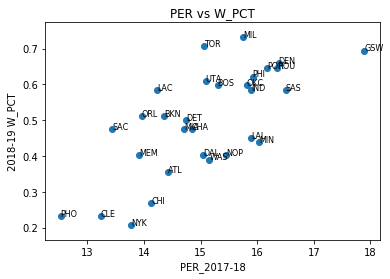

In [46]:
sdf19 = wpdf1[wpdf1["GROUP_VALUE"] == "2018-19"]
ABV = ['ATL','BOS','CLE','NOP','CHI','DAL','DEN','GSW','HOU','LAC','LAL','MIA','MIL','MIN','BKN','NYK',
       'ORL','IND','PHI','PHO','POR','SAC','SAS','OKC','TOR','UTA','MEM','WAS','DET','CHA']
plt.scatter(sdf19["PER_2017-18"],sdf19["W_PCT"])

plt.xlabel("PER_2017-18")
plt.ylabel("2018-19 W_PCT")
plt.title("PER vs W_PCT")
for i, txt in enumerate(ABV):
    plt.annotate(txt, (sdf19['PER_2017-18'].iat[i], sdf19['W_PCT'].iat[i])).set_fontsize(8)
plt.show()

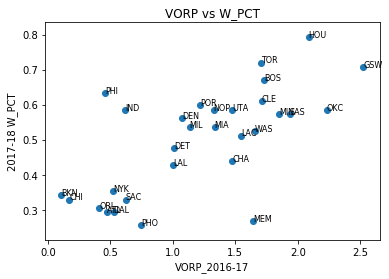

In [47]:
sdf = wpdf1[wpdf1["GROUP_VALUE"] == "2017-18"]
ABV = ['ATL','BOS','CLE','NOP','CHI','DAL','DEN','GSW','HOU','LAC','LAL','MIA','MIL','MIN','BKN','NYK',
       'ORL','IND','PHI','PHO','POR','SAC','SAS','OKC','TOR','UTA','MEM','WAS','DET','CHA']
plt.scatter(sdf["VORP_2016-17"],sdf["W_PCT"])

plt.xlabel("VORP_2016-17")
plt.ylabel("2017-18 W_PCT")
plt.title("VORP vs W_PCT")
for i, txt in enumerate(ABV):
    plt.annotate(txt, (sdf['VORP_2016-17'].iat[i], sdf['W_PCT'].iat[i])).set_fontsize(8)
plt.show()

In [48]:
bins = []
for x in wpdf1["W_PCT"]:
    if x >= 0.5:
        bins.append(1)
    else:
        bins.append(0)

wpdf1["W_PCT_BIN"] = bins

In [49]:
# wpdf1.head()

In [50]:
wpdf1.shape

(210, 323)

In [51]:
season13 = wpdf1[wpdf1["GROUP_VALUE"] == "2013-14"]
X = wpdf1.columns[7:52]

In [52]:
season13 = wpdf1[wpdf1["GROUP_VALUE"] == "2013-14"]
season13_data = season13.iloc[:,6:52]


## Feature Selection

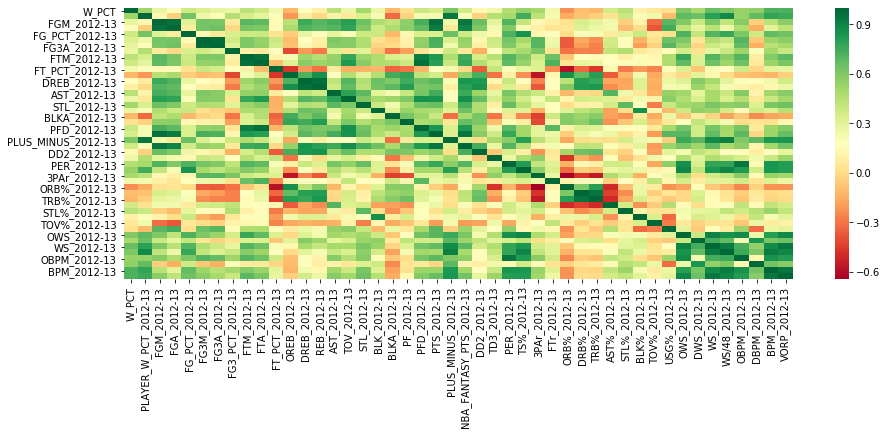

In [53]:
corrmat = season13_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,5))
sns.heatmap(corrmat, annot=False, cmap="RdYlGn")
plt.show()

In [54]:
cor_target = abs(corrmat["W_PCT"])
relevant_features = cor_target[cor_target>0.5]
relevant_features.sort_values()
relevant_features

W_PCT                   1.000000
PLAYER_W_PCT_2012-13    0.521283
STL_2012-13             0.507841
PLUS_MINUS_2012-13      0.610942
TS%_2012-13             0.545546
OWS_2012-13             0.598854
WS_2012-13              0.661813
WS/48_2012-13           0.607987
OBPM_2012-13            0.539688
DBPM_2012-13            0.559418
BPM_2012-13             0.717357
VORP_2012-13            0.720936
Name: W_PCT, dtype: float64

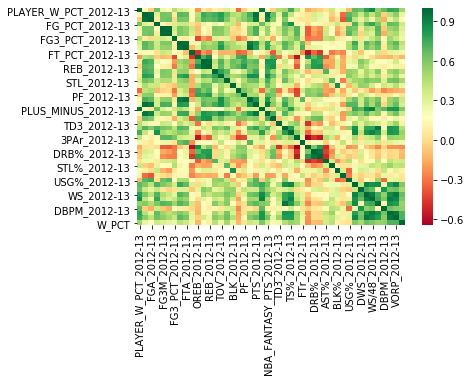

<Figure size 1080x360 with 0 Axes>

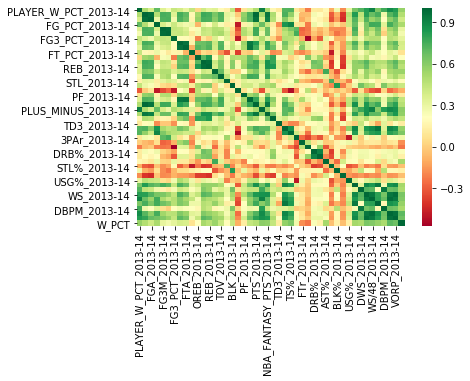

<Figure size 1080x360 with 0 Axes>

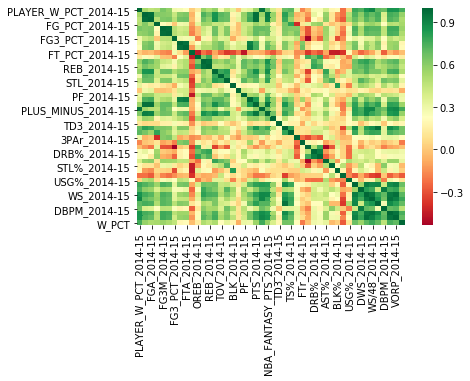

<Figure size 1080x360 with 0 Axes>

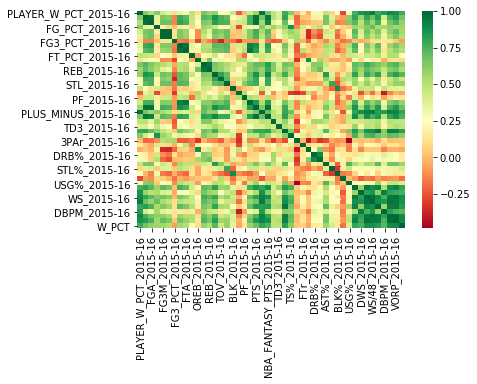

<Figure size 1080x360 with 0 Axes>

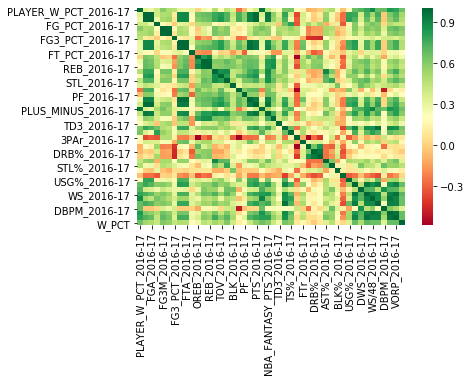

<Figure size 1080x360 with 0 Axes>

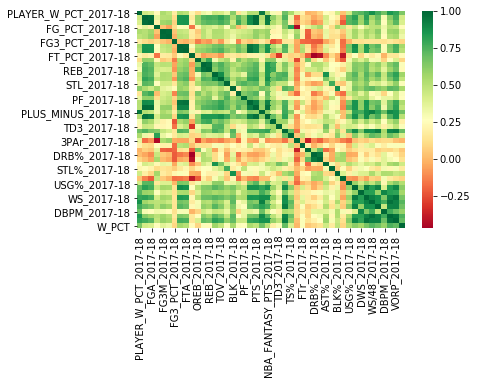

<Figure size 1080x360 with 0 Axes>

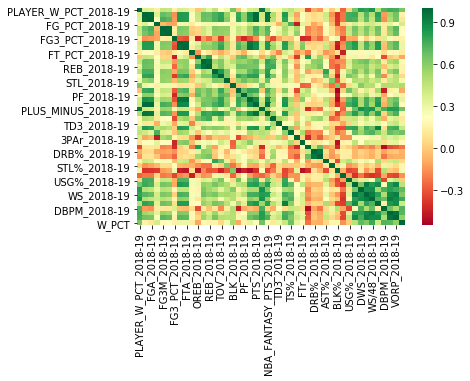

<Figure size 1080x360 with 0 Axes>

In [55]:
seasons_1 = ['2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20']
counter = 0
comb_df = pd.Series()
for i in seasons_1:
    seasonx = wpdf1[wpdf1["GROUP_VALUE"] == i]
    X1 = seasonx.iloc[:,7+counter:52+counter]
    Y1 = seasonx.iloc[:,6]
    XY1 = pd.concat([X1,Y1],axis=1)
    corrmat = XY1.corr()
    sns.heatmap(corrmat, annot=False, cmap="RdYlGn")
    plt.figure(figsize=(15,5))
    plt.show()
    cor_target = abs(corrmat["W_PCT"])
    relevant_features = cor_target[cor_target>0.5]
    comb_df = comb_df.append(relevant_features.sort_values())
    counter += 45


In [56]:
# comb_df.to_csv("./data/correlation_coefficient.csv")
comb_df

STL_2012-13                0.507841
PLAYER_W_PCT_2012-13       0.521283
OBPM_2012-13               0.539688
TS%_2012-13                0.545546
DBPM_2012-13               0.559418
OWS_2012-13                0.598854
WS/48_2012-13              0.607987
PLUS_MINUS_2012-13         0.610942
WS_2012-13                 0.661813
BPM_2012-13                0.717357
VORP_2012-13               0.720936
W_PCT                      1.000000
DWS_2013-14                0.508085
FG_PCT_2013-14             0.510748
DBPM_2013-14               0.512760
DREB_2013-14               0.523280
AST%_2013-14               0.523746
OWS_2013-14                0.533132
AST_2013-14                0.552750
PLAYER_W_PCT_2013-14       0.564692
OBPM_2013-14               0.567754
PER_2013-14                0.575897
NBA_FANTASY_PTS_2013-14    0.579267
PLUS_MINUS_2013-14         0.590588
WS/48_2013-14              0.613965
TS%_2013-14                0.628594
WS_2013-14                 0.633181
VORP_2013-14               0

In [57]:
print(season13[["VORP_2012-13","PLUS_MINUS_2012-13"]].corr())
print(season13[["VORP_2012-13","OWS_2012-13"]].corr())

                    VORP_2012-13  PLUS_MINUS_2012-13
VORP_2012-13            1.000000            0.834663
PLUS_MINUS_2012-13      0.834663            1.000000
              VORP_2012-13  OWS_2012-13
VORP_2012-13      1.000000     0.886564
OWS_2012-13       0.886564     1.000000


In [58]:
big_list = []
counter = 0
for i in seasons_1:
    seasonx = wpdf1[wpdf1["GROUP_VALUE"] == i]
    X1 = seasonx.iloc[:,7+counter:52+counter]
    Y1 = seasonx.iloc[:,6]
    XY1 = pd.concat([X1,Y1],axis=1)
    corrmat = XY1.corr()
    cor_target = abs(corrmat["W_PCT"])
    big_list.append(corrmat["W_PCT"].to_list())
    print(corrmat['W_PCT'])
#     sns.heatmap(corrmat["W_PCT"], annot=False, cmap="RdYlGn")
#     plt.show()
    counter += 45

PLAYER_W_PCT_2012-13       0.521283
FGM_2012-13                0.271648
FGA_2012-13                0.168971
FG_PCT_2012-13             0.378050
FG3M_2012-13               0.326011
FG3A_2012-13               0.279270
FG3_PCT_2012-13            0.255603
FTM_2012-13                0.438279
FTA_2012-13                0.377540
FT_PCT_2012-13             0.237803
OREB_2012-13              -0.119466
DREB_2012-13               0.168489
REB_2012-13                0.086220
AST_2012-13                0.442391
TOV_2012-13                0.258725
STL_2012-13                0.507841
BLK_2012-13                0.260282
BLKA_2012-13              -0.118030
PF_2012-13                 0.024350
PFD_2012-13                0.387099
PTS_2012-13                0.347914
PLUS_MINUS_2012-13         0.610942
NBA_FANTASY_PTS_2012-13    0.371648
DD2_2012-13                0.132123
TD3_2012-13                0.250588
PER_2012-13                0.457202
TS%_2012-13                0.545546
3PAr_2012-13               0

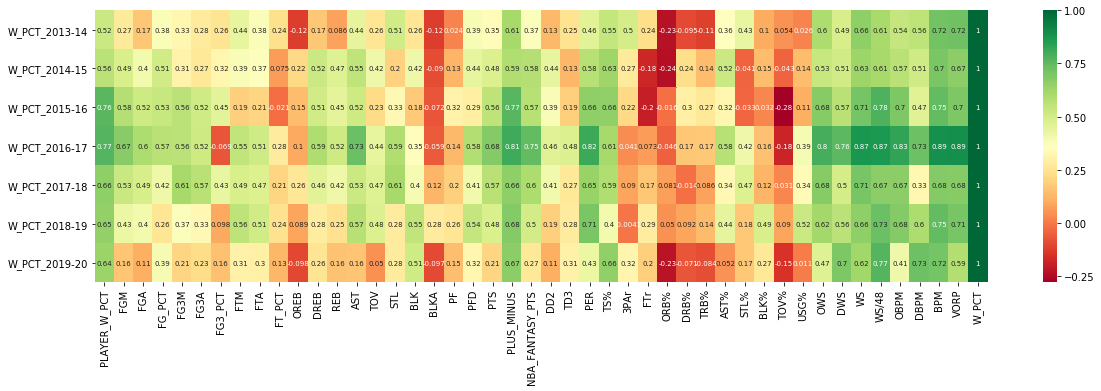

In [59]:
dict_1 = {'W_PCT_2013-14':big_list[0],'W_PCT_2014-15':big_list[1],'W_PCT_2015-16':big_list[2],
        'W_PCT_2016-17':big_list[3],'W_PCT_2017-18':big_list[4],'W_PCT_2018-19':big_list[5],
       'W_PCT_2019-20':big_list[6]}
xlabels = ['PLAYER_W_PCT', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
                       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
                       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
                       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48','OBPM', 'DBPM', 'BPM', 'VORP','W_PCT']
df_dict = pd.DataFrame(dict_1, columns=dict_1.keys())
df_transpose=df_dict.transpose()
plt.figure(figsize=(20,5))
sns.heatmap(df_transpose,xticklabels=xlabels,cmap="RdYlGn",annot=True,annot_kws={"size": 7})
plt.show()

# Model Accuracy and Error

In [60]:
metrics_scaler = pd.read_pickle('./results/metrics_scaler.pkl')
metrics_regression = pd.read_pickle('./results/metrics_seasonal_regression.pkl')

In [61]:
metrics_scaler #classification accuracy

{5: {10: 0.618,
  11: 0.6293333333333335,
  12: 0.6220000000000002,
  13: 0.6146666666666667,
  14: 0.6146666666666666,
  15: 0.6333333333333334,
  16: 0.6140000000000001,
  17: 0.628,
  18: 0.642,
  19: 0.6266666666666667,
  20: 0.6200000000000001,
  21: 0.6246666666666669,
  22: 0.6140000000000002,
  23: 0.6286666666666667,
  24: 0.6366666666666668},
 6: {10: 0.6393333333333334,
  11: 0.6246666666666668,
  12: 0.6313333333333333,
  13: 0.6453333333333333,
  14: 0.6366666666666668,
  15: 0.6433333333333335,
  16: 0.6460000000000001,
  17: 0.6446666666666667,
  18: 0.6453333333333334,
  19: 0.634,
  20: 0.6473333333333335,
  21: 0.6346666666666667,
  22: 0.6439999999999999,
  23: 0.642,
  24: 0.6440000000000002},
 7: {10: 0.6280000000000002,
  11: 0.6293333333333335,
  12: 0.6380000000000002,
  13: 0.6366666666666667,
  14: 0.6186666666666667,
  15: 0.6193333333333335,
  16: 0.6300000000000001,
  17: 0.6326666666666666,
  18: 0.6206666666666666,
  19: 0.6213333333333335,
  20: 0.626000

In [62]:
metrics_regression #regression MAE

{'2013-14': {1: '', 2: '', 3: '', 4: '', 5: ''},
 '2014-15': {1: 0.11339387499999999,
  2: 0.11288619444444435,
  3: 0.11303576388888883,
  4: 0.11276259722222229,
  5: 0.11291295833333331},
 '2015-16': {1: 0.09809105555555553,
  2: 0.11743001388888887,
  3: 0.11767958333333325,
  4: 0.11763808333333335,
  5: 0.11744962500000003},
 '2016-17': {1: 0.08185862499999999,
  2: 0.09551272222222218,
  3: 0.09393690277777779,
  4: 0.09360490277777778,
  5: 0.09368861111111113},
 '2017-18': {1: 0.08953947222222215,
  2: 0.09426173611111106,
  3: 0.11328170833333338,
  4: 0.11365947222222235,
  5: 0.11303461111111107},
 '2018-19': {1: 0.09215074999999999,
  2: 0.09059341666666666,
  3: 0.10538555555555558,
  4: 0.11556181944444445,
  5: 0.11422306944444442},
 '2019-20': {1: 0.11660847222222227,
  2: 0.12456748611111118,
  3: 0.13038790277777773,
  4: 0.13059069444444446,
  5: 0.131270132936508}}

In [63]:
scaler_list = []
keys_list = []
for k, v in metrics_scaler.items():
    keys_list.append(k)
    for k1 in v:
        scaler_list.append(v[k1])

In [64]:
scaler_list = np.array(scaler_list)
mean_list = np.mean(scaler_list.reshape(-1, 15), axis=1)
mean_list

array([0.62444444, 0.64017778, 0.62604444, 0.63866667, 0.62853333,
       0.63862222, 0.62671111, 0.63737778, 0.62582222, 0.6312    ,
       0.624     , 0.62951111, 0.62355556, 0.63124444, 0.62204444,
       0.63044444, 0.62035556, 0.63013333, 0.62244444, 0.62697778])

In [65]:
keys_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

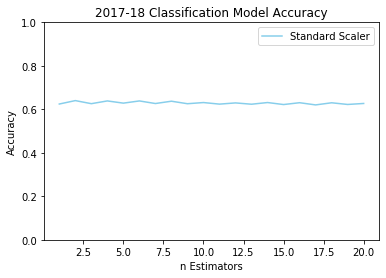

In [66]:
f, ax = plt.subplots(1)
ax.plot(range(1,21), mean_list,color='skyblue',label="Standard Scaler")  
ax.legend()
plt.xlabel("n Estimators")
plt.ylabel("Accuracy")
plt.title("2017-18 Classification Model Accuracy")
ax.set_ylim(ymin=0,ymax=1.0)
plt.show()

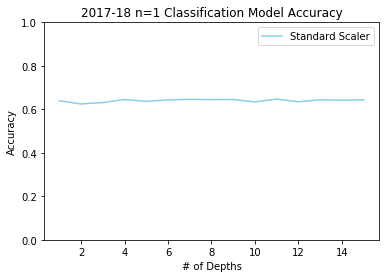

In [67]:
highest = [ 0.6393333333333334,
 0.6246666666666668,
 0.6313333333333333,
 0.6453333333333333,
 0.6366666666666668,
 0.6433333333333335,
 0.6460000000000001,
 0.6446666666666667,
 0.6453333333333334,
 0.634,
 0.6473333333333335,
 0.6346666666666667,
 0.6439999999999999,
 0.642,
 0.6440000000000002,]
f, ax = plt.subplots(1)
plt.plot(range(1,16), highest,color='skyblue',label="Standard Scaler")  
plt.legend()
plt.xlabel("# of Depths")
plt.ylabel("Accuracy")
plt.title("2017-18 n=1 Classification Model Accuracy")
ax.set_ylim(ymin=0,ymax=1.0)
plt.show()

In [68]:
season_list = []
reg_list = []
for k, v in metrics_regression.items():

    season_list.append(k)
    for k1 in v:
        reg_list.append(v[k1])

In [69]:
reg_list = reg_list[5:]
reg_list = np.array(reg_list).astype(np.float)


In [70]:
mean_list_1 = np.mean(reg_list.reshape(-1, 5), axis=1)

In [71]:
season_list = season_list[1:]

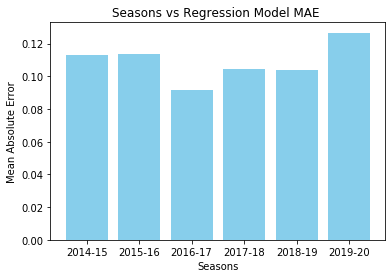

In [72]:
plt.figure()
plt.bar(season_list, mean_list_1,color='skyblue')  
plt.xlabel("Seasons")
plt.ylabel("Mean Absolute Error")
plt.title("Seasons vs Regression Model MAE ")

plt.show()

In [73]:
metrics_s = pd.read_pickle('./results/metrics.pkl')

In [74]:
metrics_s

{5: {10: 0.6206666666666668,
  11: 0.6293333333333335,
  12: 0.6460000000000001,
  13: 0.6173333333333333,
  14: 0.6340000000000001,
  15: 0.6280000000000001,
  16: 0.6213333333333333,
  17: 0.6246666666666668,
  18: 0.6346666666666668,
  19: 0.624,
  20: 0.6273333333333335,
  21: 0.638,
  22: 0.6333333333333335,
  23: 0.616,
  24: 0.6306666666666668,
  25: 0.6353333333333334,
  26: 0.6140000000000001,
  27: 0.6373333333333333,
  28: 0.5926666666666668,
  29: 0.6246666666666666},
 6: {10: 0.6386666666666666,
  11: 0.6413333333333334,
  12: 0.6213333333333335,
  13: 0.6446666666666667,
  14: 0.6260000000000002,
  15: 0.6346666666666667,
  16: 0.6373333333333334,
  17: 0.6386666666666668,
  18: 0.6473333333333335,
  19: 0.6373333333333335,
  20: 0.6386666666666669,
  21: 0.6373333333333335,
  22: 0.6480000000000001,
  23: 0.638,
  24: 0.64,
  25: 0.636,
  26: 0.6366666666666669,
  27: 0.6346666666666667,
  28: 0.6413333333333334,
  29: 0.6346666666666667},
 7: {10: 0.6153333333333334,
  

In [75]:
metrics_seasonal = pd.read_pickle('./results/metrics_seasonal.pkl')

In [76]:
metrics_seasonal

{'2013-14': {1: '', 2: '', 3: '', 4: '', 5: ''},
 '2014-15': {1: 0.6570000000000005,
  2: 0.6520000000000009,
  3: 0.6566666666666674,
  4: 0.6550000000000007,
  5: 0.6601666666666677},
 '2015-16': {1: 0.7700000000000005,
  2: 0.7633333333333334,
  3: 0.7565,
  4: 0.7546666666666668,
  5: 0.7588333333333337},
 '2016-17': {1: 0.6980000000000001,
  2: 0.6733333333333342,
  3: 0.6801666666666674,
  4: 0.6871666666666671,
  5: 0.688333333333334},
 '2017-18': {1: 0.7615,
  2: 0.6973333333333339,
  3: 0.6796666666666673,
  4: 0.6620000000000001,
  5: 0.6613333333333336},
 '2018-19': {1: 0.6416666666666676,
  2: 0.6210000000000008,
  3: 0.5821666666666665,
  4: 0.5821666666666667,
  5: 0.5824999999999999},
 '2019-20': {1: 0.6043333333333334,
  2: 0.5964999999999996,
  3: 0.5739999999999996,
  4: 0.6206666666666671,
  5: 0.6043333333333336}}

In [77]:
season_list_acc = []
reg_list_acc = []
for k, v in metrics_seasonal.items():
    season_list_acc.append(k)
    for k1 in v:
        reg_list_acc.append(v[k1])


In [78]:
reg_list_acc = reg_list_acc[5:]
reg_list_acc = np.array(reg_list_acc).astype(np.float)
reg_list_acc

array([0.657     , 0.652     , 0.65666667, 0.655     , 0.66016667,
       0.77      , 0.76333333, 0.7565    , 0.75466667, 0.75883333,
       0.698     , 0.67333333, 0.68016667, 0.68716667, 0.68833333,
       0.7615    , 0.69733333, 0.67966667, 0.662     , 0.66133333,
       0.64166667, 0.621     , 0.58216667, 0.58216667, 0.5825    ,
       0.60433333, 0.5965    , 0.574     , 0.62066667, 0.60433333])

In [79]:
mean_list_acc = np.mean(reg_list_acc.reshape(-1, 5), axis=1)

In [80]:
mean_list_acc_r = [0.75616667, 0.76066667, 0.8854    , 0.69236667, 0.6198    ,
       0.65]

In [81]:
season_list_acc = season_list_acc[1:]

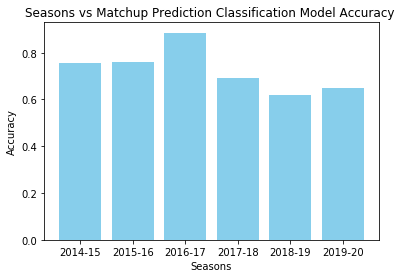

In [82]:
plt.figure()
plt.bar(season_list_acc, mean_list_acc_r,color='skyblue')  
plt.xlabel("Seasons")
plt.ylabel("Accuracy")
plt.title("Seasons vs Matchup Prediction Classification Model Accuracy ")

plt.show()

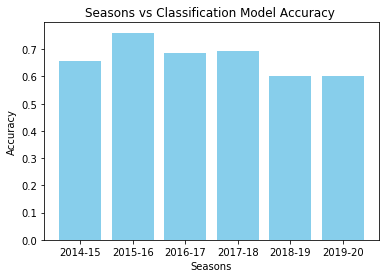

In [83]:
plt.figure()
plt.bar(season_list_acc, mean_list_acc,color='skyblue')  
plt.xlabel("Seasons")
plt.ylabel("Accuracy")
plt.title("Seasons vs Classification Model Accuracy ")

plt.show()